In [1]:
import pyodbc 
import pandas as pd
import matplotlib.pyplot as plt

## Connecting to my SQL server which is hosted in Microsoft SQL Server 18

In [2]:
driver = '{SQL Server}'
server = 'LAPTOP-S1H0GINM\MYSERVER' 
database = 'SanFran' 
table = '.dbo.Building_Permits'

conn = pyodbc.connect('Driver=' +driver+ ';'
                      'Server=' +server+ ';'
                      'Database=' +database+ ';'
                      'Trusted_Connection=yes;')

## Loading dataset from Local SQL server. The dataset originates from [kaggle.com](https://www.kaggle.com/aparnashastry/building-permit-applications-data?select=DataDictionaryBuildingPermit.xlsx). On kaggle this is the description of the dataset:

##### Background
A building permit is an official approval document issued by a governmental agency that allows you or your contractor to proceed with a construction or remodeling project on one's property. For more details go to https://www.thespruce.com/what-is-a-building-permit-1398344. Each city or county has its own office related to buildings, that can do multiple functions like issuing permits, inspecting buildings to enforce safety measures, modifying rules to accommodate needs of the growing population etc. For the city of San Francisco, permit issuing is taken care by www.sfdbi.org/

Why is this important: In the recent past, several posts and blogs highlighted that main discrepancy in demand and supply in real estate industry is due to delays in issuing building permits. Refer:
https://www.trulia.com/blog/trends/elasticity-2016/ - Introduces concept of elasticity, and nice scatterplot of various cities. A good data story!
https://biv.com/article/2014/11/city-building-permit-delays-costing-developers-tim

##### Content
The data was downloaded for the dates ranging from Jan 1st, 2013 to Feb 25th, 2018 using the filter in San Francisco open data portal. This is the exact link: https://data.sfgov.org/Housing-and-Buildings/Building-Permits/i98e-djp9/data
There are 43 columns and close to 200k records in the downloaded version (kept here). Description is separately uploaded as dictionary.

##### Thanks to
San Francisco Open Data portal for keeping and updating this data every Saturday.
A fellow Kaggler and mentor Rajiv Shah for encouraging me to think of business problems
A friend, Nandan PC, for suggesting to post it here and another friend Andrew Maguire for encouraging

Missing Data


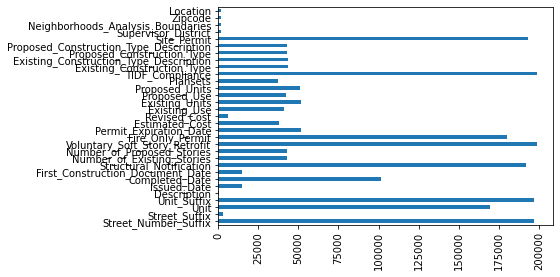

In [6]:
sql_query = pd.read_sql_query('SELECT * FROM ' +database+ table,conn)

Permits_org = pd.DataFrame(sql_query)

# Plot missing values
plt.figure(num=1)
df = Permits_org
df = df.isnull().sum()
df = df.loc[(df != 0)]
df.plot.barh()
plt.xticks(rotation=90)
print('Missing Data:')
plt.show
del df

The above graph shows the missing values in the dataset. A datapoint can be missing for one of two reasons: 

1: It never existed. An example from the dataset is the Street Number Suffix where it is perfectly normal for a builing to have the street number without a suffix like 2 instead of 2a or 2b.

2: It was not recorded but the data should have been recorded/is existing.

## Converting the below columns to Boolean instead of 'Y' and NaN
'Structural_Notification',
'Voluntary_Soft_Story_Retrofit',
'Fire_Only_Permit',
'Site_Permit'
'TIDF_Compliance'

These parameters are converted because they only have two possible values, either 'Y' which means Yes or NaN which means No. In this case the Boolean True and False are preffered.

Missing Data:


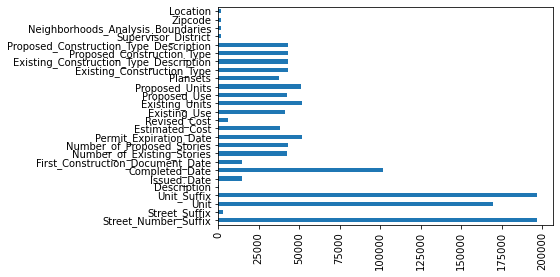

In [7]:
Permits_bool = Permits_org.copy()

cols_bool = ['Structural_Notification',
             'Voluntary_Soft_Story_Retrofit',
             'Fire_Only_Permit',
             'Site_Permit']
Permits_bool[cols_bool] = Permits_bool[cols_bool].replace([None, 'Y'], [False, True])

# adding exception for TIDF where there is a misrecorded P expected to be a Y
Permits_bool['TIDF_Compliance'] = Permits_bool['TIDF_Compliance'].replace([None, 'Y', 'P'], [False, True, True])

# Plot missing values
plt.figure(num=2)
df = Permits_bool
df = df.isnull().sum()
df = df.loc[(df != 0)]
df.plot.barh()
plt.xticks(rotation=90)
print('Missing Data:')
plt.show
del df

Now the amont of columns with missing data is reduced.

## Filling in
'Supervisor_District'
'Neighborhoods_Analysis_Boundaries'
'Zipcode'
'Location' 
#### Based on 
'Street_Name'
'Street_Suffix'
'Street_Number'
'Street_Number_Suffix'

The 4 above parameters is expected to be missing since all permits should be located within a distric and with a zipcode and location. Therfore the Street Name, Suffix, Numner, an Number Suffix is used to find the closest located permit and then the Zipcode etc. is used from that permit.

Missing Data:


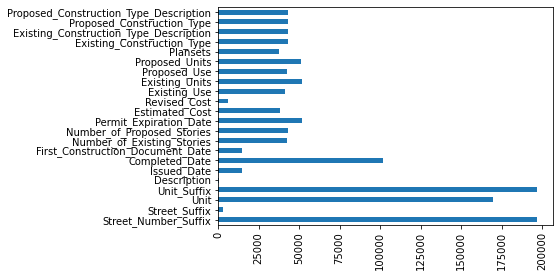

In [10]:
Permits_sorted = Permits_bool.copy()

Permits_sorted = Permits_bool.sort_values(
    ['Street_Name', 'Street_Suffix','Street_Number','Street_Number_Suffix'], 
    ascending=[True, True, True, True])

cols = ['Supervisor_District', 'Neighborhoods_Analysis_Boundaries', 'Zipcode', 'Location']
Permits_sorted.loc[:,cols] = Permits_sorted.loc[:,cols].ffill()

# Plot missing values
plt.figure(num=3)
df = Permits_sorted
df = df.isnull().sum()
df = df.loc[(df != 0)]
df.plot.barh()
plt.xticks(rotation=90)
print('Missing Data:')
plt.show
del df

## Finding the descriptions for the remaining columns with NaN to determine if rest of the Column can be accepted with NaN's

In [11]:
df = Permits_sorted.copy()
df = df.isnull().sum()
df = df.loc[(df != 0)]
df = df.index


table = '.dbo.DataDictionaryBuildingPermitUpdate'

sql_query = pd.read_sql_query('SELECT * FROM ' +database+ table,conn)

Description = pd.DataFrame(sql_query)
#Description = Description.drop_duplicates(subset="Column name", keep = "first")
Description['Column name'] = Description['Column name'].replace(' ','_',regex=True)

Description_remaining = Description.loc[Description['Column name'].isin(df)]
print(Description_remaining)

    Sl No                             Column name  \
7     8.0                    Street_Number_Suffix   
9    10.0                           Street_Suffix   
10   11.0                                    Unit   
11   12.0                             Unit_Suffix   
12   13.0                             Description   
16   17.0                             Issued_Date   
17   18.0                          Completed_Date   
18   19.0        First_Construction_Document_Date   
20   21.0              Number_of_Existing_Stories   
21   22.0              Number_of_Proposed_Stories   
24   25.0                  Permit_Expiration_Date   
25   26.0                          Estimated_Cost   
26   27.0                            Revised_Cost   
27   28.0                            Existing_Use   
28   29.0                          Existing_Units   
29   30.0                            Proposed_Use   
30   31.0                          Proposed_Units   
31   32.0                                Plans

## Below is a reasoning why the column is accepted with NaN if it is accepted

In [16]:
Reasoning = ['Not existing for all Street Numbers',
            'Not existing for all Streets',
            'Can be missing because it involves more than one unit',
            'Can be missing because it involves more than one unit or Not existing for unit',
            'Should be recorded if permit is not withdrawn, cancled or complete',
            'Permit was never or is not yet issued see Current_Status',
            'Project was never started or is not yet completed see Current_Status',
            'Project was never started or is not yet started',
            'There were no existing stories',
            'The permit did not relate to construction a building with stories or is about a demolition',
            'The permit was never or is not yet issued and does therefore not expire',
            'Should be recorded if permit is not withdrawn, cancled or complete',
            'Should be recorded if permit is not withdrawn, cancled or complete',
            'Should be recorded if permit is not withdrawn, cancled or complete',
            'Should be recorded if permit is not withdrawn, cancled or complete',
            'Should be recorded if permit is not withdrawn, cancled or complete',
            'Should be recorded if permit is not withdrawn, cancled or complete',
            'Could be a street space or vacant lot and does therfore not have a foundation',
            'Could be a street space or vacant lot and does therfore have any existing construction',
            'Could be a street space or vacant lot and does therfore have any existing construction',
            'Could be a street space or vacant lot and does therfore have any proposed construction',
            'Could be a street space or vacant lot and does therfore have any proposed construction',
            ]

Description_remaining['Reasoning'] = Reasoning

<ipython-input-16-f1210cdfe5e7>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Description_remaining['Reasoning'] = Reasoning


## Plotting the final columns that are not accepted with NaN's 

Columns with missing values that are not accepted:


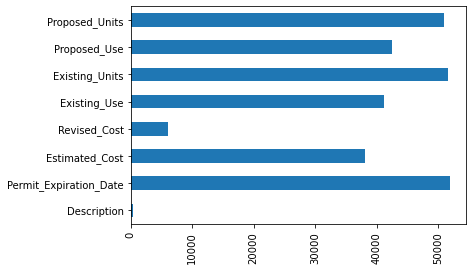

In [15]:
Permits_accepted = Permits_sorted.copy()
columns_drop = ['Street_Number_Suffix',
                'Street_Suffix',
                'Unit',
                'Unit_Suffix',
                'Issued_Date',
                'Completed_Date',
                'First_Construction_Document_Date',
                'Number_of_Existing_Stories',
                'Number_of_Proposed_Stories',
                'Plansets',
                'Existing_Construction_Type',
                'Existing_Construction_Type_Description',
                'Proposed_Construction_Type',
                'Proposed_Construction_Type_Description']


# Plot missing values
plt.figure(num=4)
df = Permits_accepted.drop(columns_drop, axis=1)
df = df.isnull().sum()
df = df.loc[(df != 0)]
df.plot.barh()
plt.xticks(rotation=90)
print('Columns with missing values that are not accepted:')
plt.show
del df

## Conclusions:
The columns in the above graph should be recorded for permits that are not withdrawn, cancled, or complete if the depending on the aplication of the data. In some other cases it might be better to exclide the rows with the NaN's.